# Dota API match data EDA

This script covers the initial data exploration for feature extraction as well as tests for the engineering of the data preprocessing pipeline.

## Setup

### Imports

In [37]:
import requests
import os
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import game_data_collector.parse_game_data_utils as pgdu
import game_data_collector.api as dapi
from database import MongoDB

plots_out_dir = os.path.join("..", "resources", "plots", "initial_feature_selection")


### Get Heroes from OpenDota API (real time)

**With Explorer API (alternatively)**  
Note: Uses PostgreSQL 9.5.10: SELECT version();  

Get heroes table columns and types:  
`SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'heroes';`  

Get all heroes:  
`SELECT * from heroes ORDER by heroes.id ASC;`

#### All heroes

In [38]:
# Get the list of heroes from the API
res: requests.Response = pgdu.make_request_with_retries("https://api.opendota.com/api/heroes")
heroes: list[dict] = []
if res.status_code != 200:
    raise ValueError(f'Failed to retrieve data: {res.status_code}')
else:
    heroes = json.loads(res.text)

# print(heroes)

In [39]:
heroes_ids_roles = pd.DataFrame(heroes, columns=["id", "localized_name", "attack_type"]).set_index('id', drop=True) # 145 heroes in total
print(heroes_ids_roles)

     localized_name attack_type
id                             
1         Anti-Mage       Melee
2               Axe       Melee
3              Bane      Ranged
4       Bloodseeker       Melee
5    Crystal Maiden      Ranged
..              ...         ...
135     Dawnbreaker       Melee
136           Marci       Melee
137    Primal Beast       Melee
138          Muerta      Ranged
145             Kez       Melee

[126 rows x 2 columns]


#### Filter by role

Distinct roles are: Carry, Durable, Escape, Initiator, Disabler, Nuker, Support, Pusher (heroes can have multiple roles!)  
`SELECT DISTINCT roles from heroes;`  

Get all heroes that are flagged as 'Carry':  
`SELECT * from heroes WHERE 'Carry' = ANY(roles) ORDER by heroes.id ASC;`

Role.CANONICAL_CARRY is a custom set of predefined heroes

In [40]:
# Sample call
print(dapi.get_hero_ids_of_role(dapi.Role.CANONICAL_CARRY))

[1, 4, 6, 8, 12, 18, 41, 44, 46, 48, 54, 56, 59, 61, 67, 72, 77, 80, 81, 94, 109]


### DB Connection (to cached match data)

In [41]:
db = MongoDB(username='root', password='example')
db.connect_db()
db.get_database("mmr_predictor")
col = db.get_collection("dota_game_collection")

## Database queries (MongoDB)

In [42]:
# Sample document structure

res = col.find_one()
# pprint.pprint(res)

### Unique matches and players

In [43]:
print(f"Found {col.count_documents({}):,} recorded matches with {len(col.distinct('players.account_id')):,} unique players in the database.")

# First batch has 5180 matches and 20799 unique players of whom 18356 are in tier (11, 80)


Found 17,048 recorded matches with 73,122 unique players in the database.


### Match duration

In [44]:
# Query basic match duration statistics within mongo itself (a pipeline)

# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "mean": { "$avg": "$duration" },
            "min": { "$min": "$duration" },
            "max": { "$max": "$duration" },
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    },
    {
        "$addFields": {
            "std": { #
                "$sqrt": {
                    "$avg": {
                        "$map": {   # sum?
                            "input": "$durations",
                            "as": "duration",
                            "in": {
                                "$pow": [{ "$subtract": ["$$duration", "$mean"] }, 2] # (x_i - x_avg))**2
                            }
                        }
                    }
                }
            }
        }
    },
    {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "min": 1,
            "max": 1,
            "mean": 1,
            "std": 1
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))

if result:
    print(f"Match duration min={result[0]['min']/60:.1f} min, max={result[0]['max']/60:.1f} min, avg={result[0]['mean']/60:.1f} min, std={result[0]['std']/60:.1f} min")

Match duration min=25.0 min, max=82.2 min, avg=30.8 min, std=4.1 min


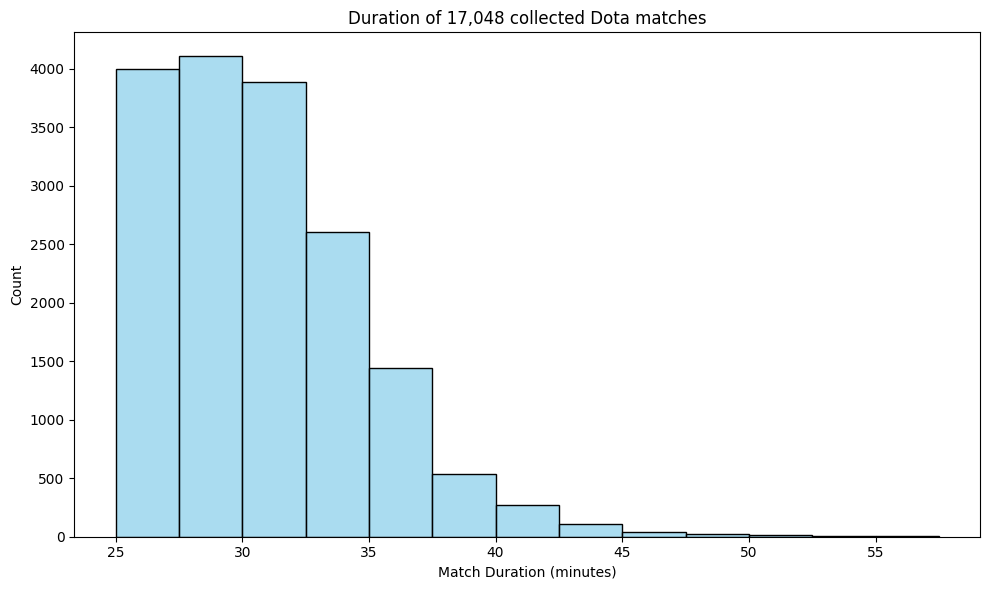

In [45]:
# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))
t_min = np.array(result[0]["durations"]) / 60

# Create the histogram
plt.figure(figsize=(10, 6))

# Set the style using seaborn
# sns.set_theme(style="whitegrid")

# IMPORTANT match duration cut of is set to 25 mins in game_data_collector.validate_clean_match_data
# Define bin edges for 2.5-minute intervals from 25 to 60
bins = np.arange(25, 60, 2.5)  

# Plot histogram using sns.histplot
sns.histplot(
    t_min,
    bins=bins,
    kde=False,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

# Customize x-ticks to show every 5 minutes
plt.xticks(np.arange(25, 60, 5))

# Labeling x and y axis, and title
plt.xlabel('Match Duration (minutes)')
plt.ylabel('Count')
plt.title(f'Duration of {len(t_min):,} collected Dota matches')

# Enhance layout
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join(plots_out_dir, "match_duration.png"))
plt.show()


### Players Rank Tiers

#### Distinct tiers

In [46]:
# There are 5*8 Dota 2 MMR ranks: https://dota2freaks.com/ranks/
# There are 8 different tiers, with 5 levels each: Herald, Guardian, Crusader, Archon, Legend, Ancient Divine Immortal
# I think this explains the data showing (None-10) 11-15, 21-25, 31-35 etc

# IMPORTANT: Immortal (Rank 8) is "placed", and contains Top 1 to 1000 players (huge bin)

distinct_tiers = col.distinct("players.rank_tier")
print(f"Found {len(distinct_tiers)} different rank tiers: {distinct_tiers}")

Found 36 different rank tiers: [None, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55, 61, 62, 63, 64, 65, 71, 72, 73, 74, 75, 80]


#### Rank tiers of players

In [47]:
# get all players excluding ranks min (None) and max (80)
rank_tiers: list[int] = []

pipeline = [
    {"$unwind": "$players"}, # Unwind the players array
    {"$match": {"players.rank_tier": {"$nin": [None, 80]}}},         # Match only documents where rank_tier is not min or max
    {"$group": {"_id": None, "rank_tiers": {"$push": "$players.rank_tier"}}}, # Collect all player ranks (including duplicates)
    {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
]

# just replacing None with 0
# pipeline = [
#     {"$unwind": "$players"}, # Unwind the players array
#     {"$group": {"_id": None, "rank_tiers": {"$push": {"$ifNull": ["$players.rank_tier", 0]}}}},  # replace None by 0
#     {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
# ]

res = col.aggregate(pipeline)

for r in res:   # assuming there is only one result entry
    rank_tiers = r['rank_tiers']
    
print(f"{len(rank_tiers):,} of {len(col.distinct('players.account_id')):,} recorded players ({(len(rank_tiers)/len(col.distinct('players.account_id')))*100:.1f} %) are in Ranks 12 - 75")

65,588 of 73,122 recorded players (89.7 %) are in Ranks 12 - 75


[11, 21, 31, 41, 51, 61, 71, 81]


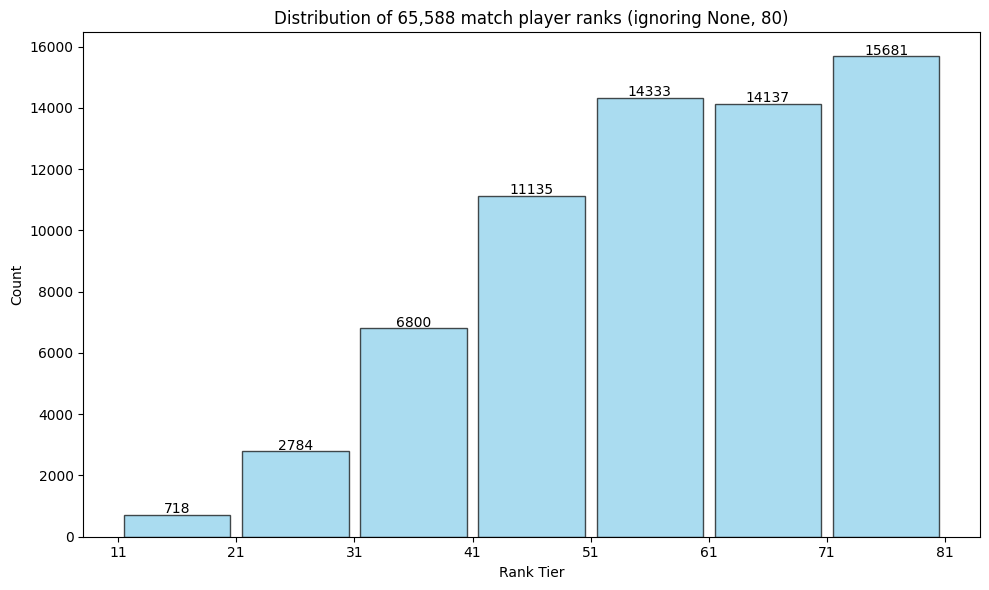

In [48]:
# Create the histogram
plt.figure(figsize=(10, 6))
bins = range(11, 91, 10)  # Bins from 0 to 80 with a width of 10
print(list(bins))

bar_width = 0.9 * (bins[1] - bins[0]) 

# Plot histogram
counts, _, patches = plt.hist(rank_tiers, bins=bins, density=False, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.9)

# Labeling x and y axis, and title
plt.xlabel('Rank Tier')
plt.ylabel('Count',)
plt.title(f'Distribution of {len(rank_tiers):,} match player ranks (ignoring None, 80)')

# Set x-ticks at intervals of 10
plt.xticks(range(11, 91, 10))

# Display counts on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{int(count)}', ha='center')

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(plots_out_dir, "rank_tiers.png"))
plt.show()

### Match Feature Exploration

Currently supported KPIs are

|KPI|attr|description|supplemental|
|---|---|---|---|
|kda|kda|kill-death-assist-ratio $\frac{k+a}{d}$|[reddit](https://www.reddit.com/r/DotA2/comments/20dnc8/what_is_a_good_kda_ratio/)|
|last hit|last_hit|get final hit of a creep, hero or building||
|apm|actions_per_min|avg. control input count of player|[reddit](https://www.reddit.com/r/learndota2/comments/6f0n5a/can_somebody_explain_actions_per_minute_to_me/)|
|gpm|gold_per_min|depends on factors like match duration and last hit count of buildings|[reddit](https://www.reddit.com/r/DotA2/comments/srgpw/whats_an_average_gold_per_minute/)|
|xpm|xp_per_min|hero xp gained per match, kill xp is shared between all allies in a defined radius|[dota2 fandom](https://dota2.fandom.com/wiki/Experience)|


#### Summarizing

In [49]:
# KPI stats of all players
df_all = dapi.get_kpis_by_role(col, dapi.Role.CANONICAL_CARRY).drop(columns = "hero_id") # TODO this method sometimes behaves unpredictably when you change the rank filter !?


collected 10003 rows


In [50]:
# map and reduce rank tiers to categorical data

# short version
# df_all["rank_tier"].apply(lambda x: x // 10).astype("category")

# more advanced, using bin grouping
# https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

# Option A
df_all["rank_group"] = (df_all["rank_tier"] // 10).astype("category")

# Option B factor with range
# labels = ["{0} - {1}".format(i, i + 9) for i in range(0, 80, 10)] 

# Option C with names
# ranks = ["Herald", "Guardian", "Crusader", "Archon", "Legend", "Ancient", "Divine", "Immortal"] 
# labels = [f"{ranks[i // 10]} {i}-{i+9}" for i in range(0, 80, 10)]
# df_all["rank_group"] = pd.cut(df_all["rank_tier"], range(0, 85, 10), right=False, labels=labels).astype("category")

In [51]:
print(df_all.head(n=5))
print()
print(df_all.describe())

   rank_tier   kda  last_hits  actions_per_min  gold_per_min  xp_per_min  \
0         74  1.25        125              281           408         460   
1         75  1.83        280              349           578         796   
2         45  5.33        330              154           654         719   
3         51  0.55        160              272           458         472   
4         71  7.00        296              320           760        1001   

  rank_group  
0          7  
1          7  
2          4  
3          5  
4          7  

          rank_tier           kda     last_hits  actions_per_min  \
count  10003.000000  10003.000000  10003.000000     10003.000000   
mean      54.030491      4.462525    221.105968       240.932320   
std       15.182729      5.166149     82.234773        93.890658   
min       12.000000      0.000000      7.000000        40.000000   
25%       43.000000      1.140000    165.500000       155.000000   
50%       54.000000      2.500000    216.000

#### Explorative PCA Analysis

In [52]:
# normalize features because of different data scale
# drop rank tier at it is our target variable
df_all_norm_vals = StandardScaler().fit_transform(df_all.drop(columns=["rank_tier", "rank_group"]))
print(f"normalized mean = {np.mean(df_all_norm_vals)}, std = {np.std(df_all_norm_vals)}")
print()

df_all_norm = pd.DataFrame(df_all_norm_vals, columns=df_all.columns[1:-1])
print(df_all_norm.head())
print(df_all_norm.shape)


normalized mean = -4.837344827078159e-17, std = 1.0

        kda  last_hits  actions_per_min  gold_per_min  xp_per_min
0 -0.621873  -1.168736         0.426770     -1.017617   -1.048790
1 -0.509598   0.716205         1.151053      0.103430    0.638108
2  0.167924   1.324251        -0.925935      0.604604    0.251527
3 -0.757377  -0.743104         0.330909     -0.687898   -0.988544
4  0.491198   0.910780         0.842167      1.303610    1.667318
(10003, 5)


In [53]:
pca = PCA(n_components=len(df_all_norm.columns))
pc_all_kpis_vals = pca.fit_transform(df_all_norm_vals)

pc_all_kpis = pd.DataFrame(pc_all_kpis_vals, columns=[f"PC{n}" for n in range(1, pc_all_kpis_vals.shape[1]+1)])
print(pc_all_kpis.head())
print(pc_all_kpis.shape)

        PC1       PC2       PC3       PC4       PC5
0 -1.843506  0.794598  0.142319 -0.132430  0.051140
1  0.735726  0.886647 -1.043259 -0.092728 -0.301694
2  0.990753 -1.208068 -0.448066  0.634563  0.153471
3 -1.499126  0.585148 -0.182730 -0.016095  0.249637
4  2.387882  0.388486 -0.361873 -0.503637 -0.147927
(10003, 5)


In [54]:
# PVE
print('Proportion of Variance Explained per PC:', pca.explained_variance_ratio_)

Proportion of Variance Explained per PC: [0.58662828 0.18882849 0.15156055 0.05336901 0.01961367]


In [55]:
pca.components_

array([[ 0.38970101,  0.46304897,  0.17443497,  0.5590619 ,  0.53920404],
       [ 0.04748014, -0.18071005,  0.97279854, -0.07920884, -0.11170706],
       [ 0.82247474, -0.53758959, -0.15048749,  0.0219088 , -0.10680007],
       [ 0.37062424,  0.66996903,  0.01812096, -0.2458832 , -0.59413151],
       [-0.17902998, -0.12275364, -0.01614252,  0.7875514 , -0.57652582]])

In [56]:
print(f"Most important features for PC1 ({pca.explained_variance_ratio_[0]:.2} of PVE):\n")

for f, i in sorted(zip(df_all.columns[1:-1], pca.components_[0]), key=lambda x: x[1], reverse=True):
    print(f"{i:.2}\t{f}")
    
print(f"\nMost important features for PC2 ({pca.explained_variance_ratio_[1]:.2} of PVE):\n")

for f, i in sorted(zip(df_all.columns[1:-1], pca.components_[1]), key=lambda x: x[1], reverse=True):
    print(f"{i:.2}\t{f}")
    
print(f"\nMost important features for PC3 ({pca.explained_variance_ratio_[2]:.2} of PVE):\n")

for f, i in sorted(zip(df_all.columns[1:-1], pca.components_[2]), key=lambda x: x[1], reverse=True):
    print(f"{i:.2}\t{f}")
    
# Dimension 4, 5 are way less important, I will ignore them!

Most important features for PC1 (0.59 of PVE):

0.56	gold_per_min
0.54	xp_per_min
0.46	last_hits
0.39	kda
0.17	actions_per_min

Most important features for PC2 (0.19 of PVE):

0.97	actions_per_min
0.047	kda
-0.079	gold_per_min
-0.11	xp_per_min
-0.18	last_hits

Most important features for PC3 (0.15 of PVE):

0.82	kda
0.022	gold_per_min
-0.11	xp_per_min
-0.15	actions_per_min
-0.54	last_hits


**Interpreting the PCA results**

- PC1 "Farming efficiency dimension" captures the primary pattern in the data (> 50 %)
    - match economy and resource management seems more important than kda (gold, xp)

- PC2 "activity dimension" is still considerable (19 %)
    - strongly influenced by how active a player is during the game
    - The negative weights on gold_per_min, xp_per_min, and last_hits imply that there is an slight inverse relationship between resource accumulation and apm ????

- PC3 "combat efficiency dimension" might be considerable (15 %)
    - Almost same importance as PC2 !
    - Separated from farming metrics
TODO this can be improved

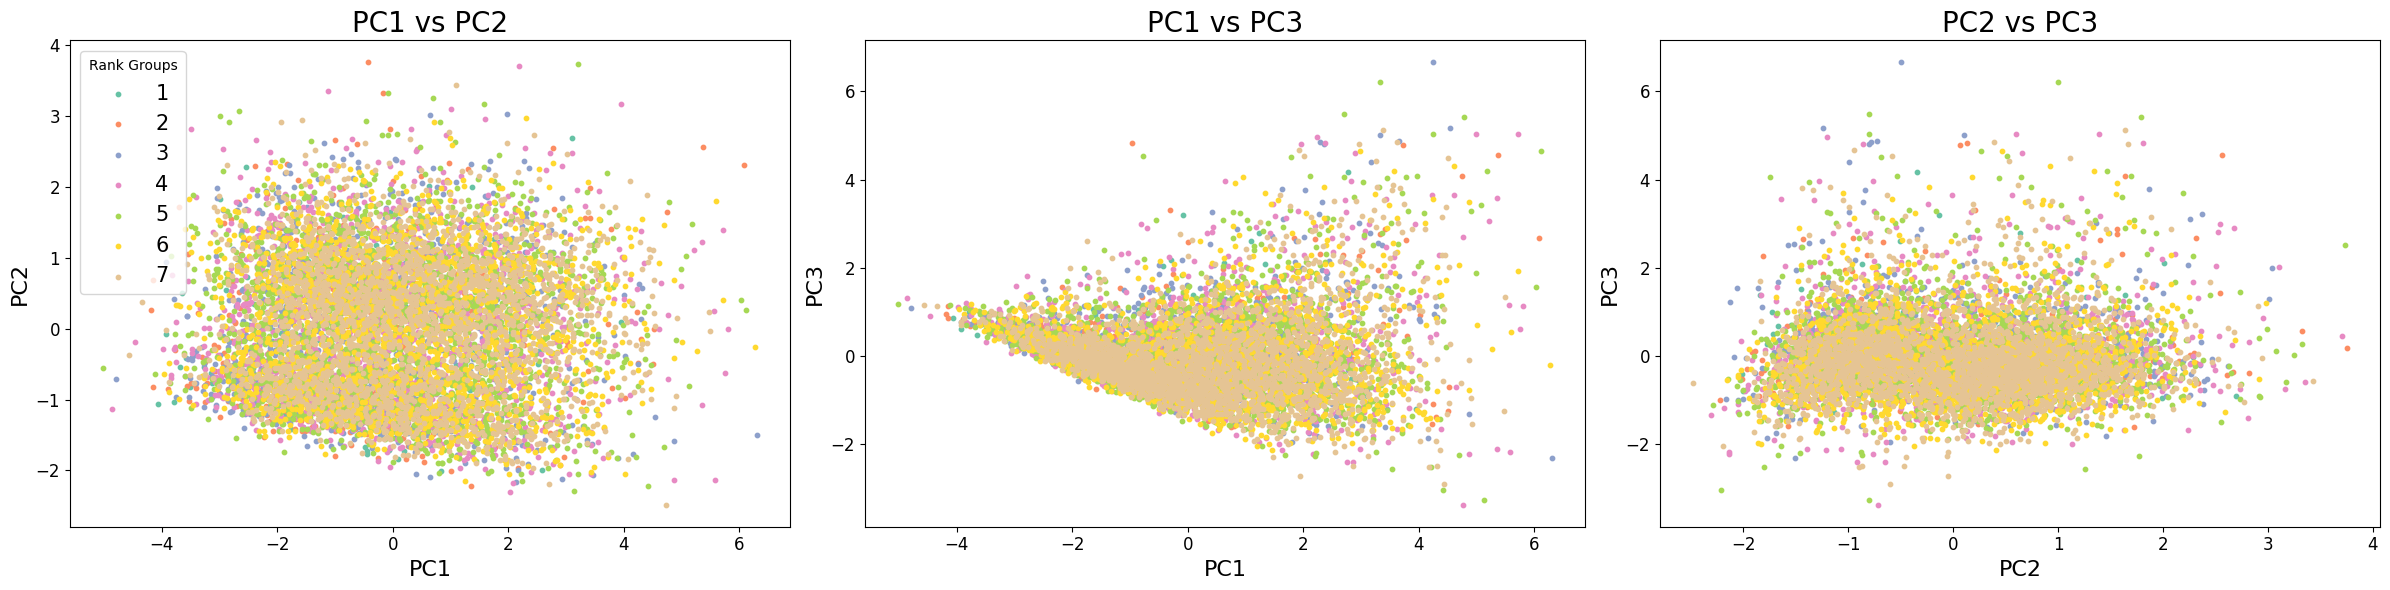

In [57]:
# Try plot the PC1 & PC2

# TODO this visualisation can be improved, maybe 3d?
# TODO interpret the plots

# assign colors to groups
ranks = sorted(df_all["rank_group"].unique())
colors = sns.color_palette('Set2', n_colors=len(df_all["rank_group"].unique()))

# for rank, color in zip(ranks,colors):
#     print(rank, color) # RGB

# Setup figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes = axes.flatten()  # Flatten to easily index subplots
titles = [
    "PC1 vs PC2",
    "PC1 vs PC3",
    "PC2 vs PC3"
]
x_labels = ["PC1", "PC1", "PC2"]
y_labels = ["PC2", "PC3", "PC3"]

ranks = sorted(df_all["rank_group"].unique())
colors = sns.color_palette('Set2', n_colors=len(ranks))

# Subplot indices
pairs = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]

for i, (x_pc, y_pc) in enumerate(pairs):
    ax = axes[i]
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(x_labels[i], fontsize=16)
    ax.set_ylabel(y_labels[i], fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    for rank, color in zip(ranks, colors):
        indicesToKeep = df_all['rank_group'] == rank
        ax.scatter(
            pc_all_kpis.loc[indicesToKeep, x_pc], 
            pc_all_kpis.loc[indicesToKeep, y_pc], 
            color=color, s=10, label=rank
        )

axes[0].legend(ranks, prop={'size': 15}, title="Rank Groups", loc="best")

plt.tight_layout()
plt.savefig(os.path.join(plots_out_dir, "features_pca.png"))
plt.show()

#### KPI correlations

In [58]:
# This is without rank tiers 0 and 80 !
df_any = dapi.get_kpis_by_role(col, dapi.Role.ANY)
df_cc = dapi.get_kpis_by_role(col, dapi.Role.CANONICAL_CARRY)

collected 65588 rows
collected 10003 rows


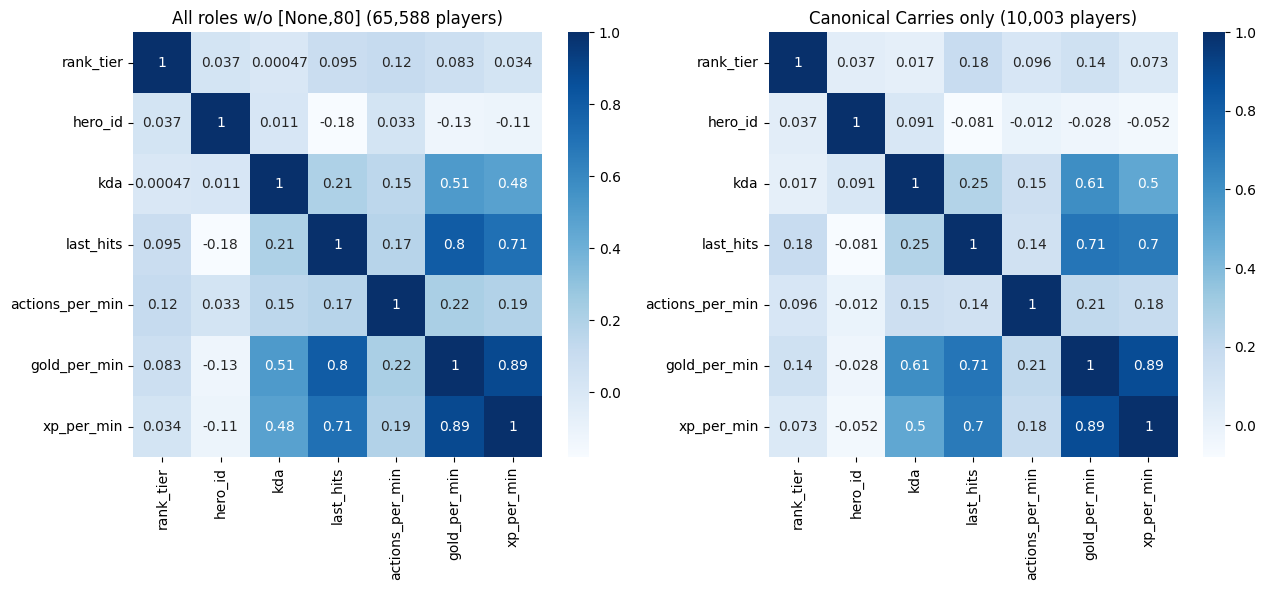

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Compute correlation matrix for df1 and plot it on the first subplot
matrix1 = df_any.corr()
sns.heatmap(matrix1, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title(f'All roles w/o [None,80] ({len(df_any):,} players)')

# Compute correlation matrix for df2 and plot it on the second subplot
matrix2 = df_cc.corr()
sns.heatmap(matrix2, annot=True, cmap='Blues', ax=axes[1])
axes[1].set_title(f'Canonical Carries only ({len(df_cc):,} players)')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.savefig(os.path.join(plots_out_dir, "features_corr_matrix.png"))
plt.show()

In [60]:
print(df_cc.head())

   rank_tier  hero_id   kda  last_hits  actions_per_min  gold_per_min  \
0         74       61  1.25        125              281           408   
1         75       18  1.83        280              349           578   
2         45        8  5.33        330              154           654   
3         51       61  0.55        160              272           458   
4         71       18  7.00        296              320           760   

   xp_per_min  
0         460  
1         796  
2         719  
3         472  
4        1001  


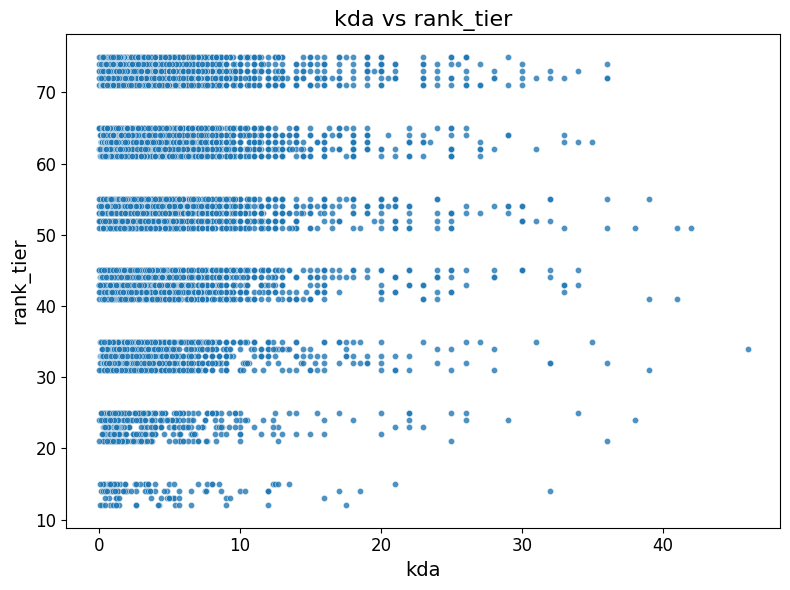

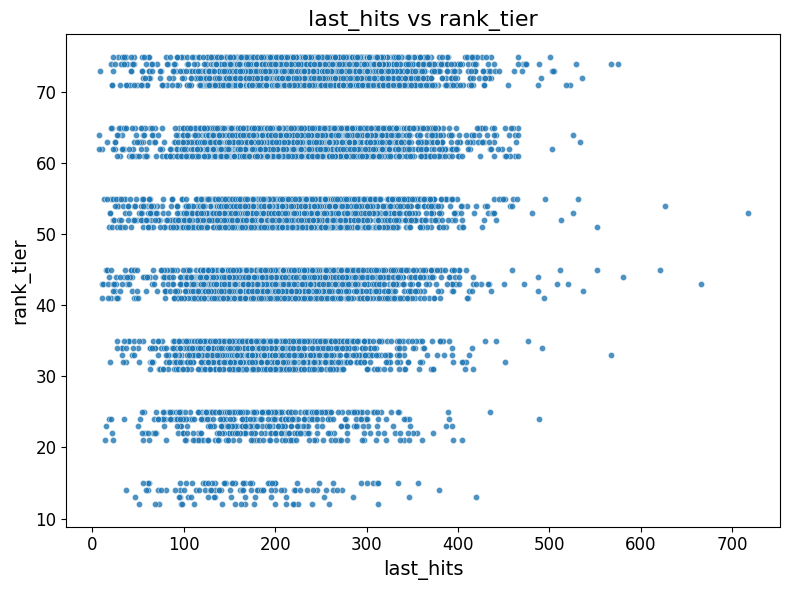

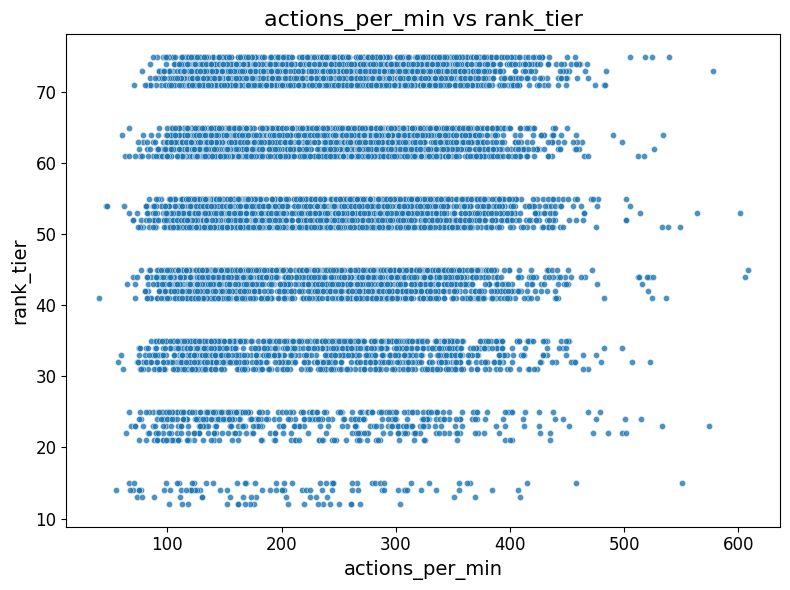

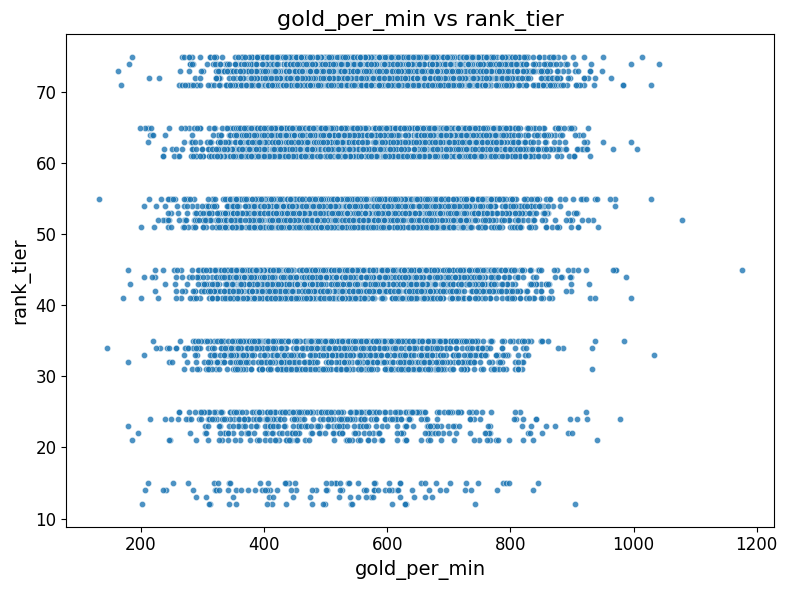

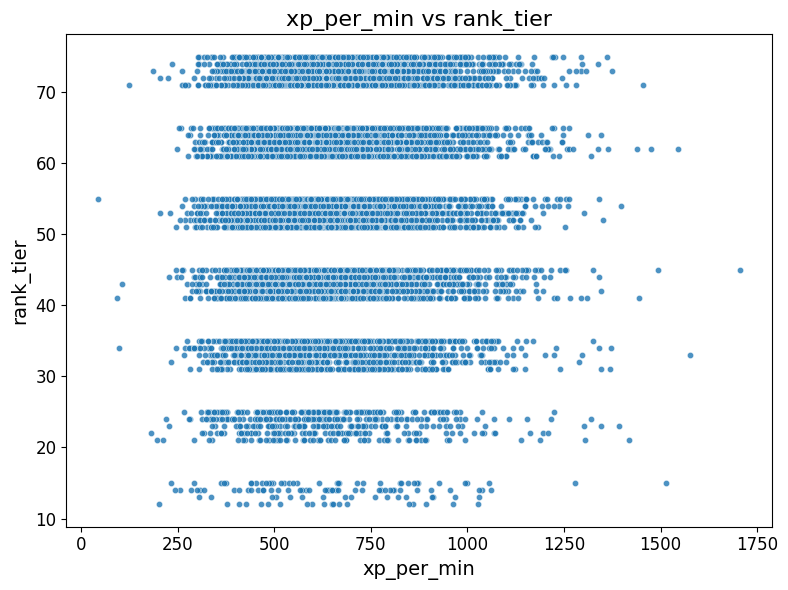

In [61]:

# Target variable (first column)
target_var = df_cc.columns[0]
predictor_vars = df_cc.columns[2:]  # Remaining columns as features

# Generate a separate scatter plot for each feature
for idx, predictor in enumerate(predictor_vars):
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    sns.scatterplot(
        x=df_cc[predictor], 
        y=df_cc[target_var],
        s=20, 
        alpha=0.8
    )
    plt.title(f"{predictor} vs {target_var}", fontsize=16)
    plt.xlabel(predictor, fontsize=14)
    plt.ylabel(target_var, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_out_dir, f"features_scatter_0{idx}.png"))
    plt.show()


#### KPIs by hero role

In [62]:
# get stats summary for each role
# CAVE: One hero can have multiple roles

all_stats_mean: list[pd.Series] = []

for role in tqdm(dapi.Role):
    
    # skip
    if role == dapi.Role.ANY:
        continue
    
    df_ = dapi.get_kpis_by_role(col, role)
    df_.drop("hero_id", axis=1, inplace=True)
    role_mean = df_.mean().round(2) # get mean of all kpis
    role_mean = pd.concat([role_mean, pd.Series({"count": len(df_)})]) # add sample count
    all_stats_mean.append(role_mean.rename(role.name))
    
df_stats_mean: pd.DataFrame = pd.DataFrame(all_stats_mean)

# MEAN !
print(df_stats_mean)

 20%|██        | 2/10 [00:01<00:07,  1.04it/s]

collected 37397 rows


 30%|███       | 3/10 [00:03<00:09,  1.36s/it]

collected 47821 rows


 40%|████      | 4/10 [00:05<00:08,  1.49s/it]

collected 24280 rows


 50%|█████     | 5/10 [00:07<00:08,  1.62s/it]

collected 25350 rows


 60%|██████    | 6/10 [00:09<00:06,  1.69s/it]

collected 27097 rows


 70%|███████   | 7/10 [00:11<00:05,  1.73s/it]

collected 48541 rows


 80%|████████  | 8/10 [00:12<00:03,  1.73s/it]

collected 11713 rows


 90%|█████████ | 9/10 [00:14<00:01,  1.68s/it]

collected 26277 rows


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

collected 10003 rows
                 rank_tier   kda  last_hits  actions_per_min  gold_per_min  \
CARRY                54.47  4.36     174.27           237.86        514.30   
DISABLER             54.53  3.86     119.05           227.82        437.97   
DURABLE              54.49  4.17     143.80           234.87        473.63   
ESCAPE               55.10  4.17     143.60           240.17        471.33   
INITIATOR            54.55  3.71     118.05           228.44        438.24   
NUKER                54.74  3.89     121.44           229.32        444.10   
PUSHER               54.26  4.00     161.30           234.02        490.80   
SUPPORT              54.10  3.66      82.71           217.33        389.24   
CANONICAL_CARRY      54.03  4.46     221.11           240.93        562.32   

                 xp_per_min    count  
CARRY                616.22  37397.0  
DISABLER             542.27  47821.0  
DURABLE              572.04  24280.0  
ESCAPE               582.20  25350.0  
INI

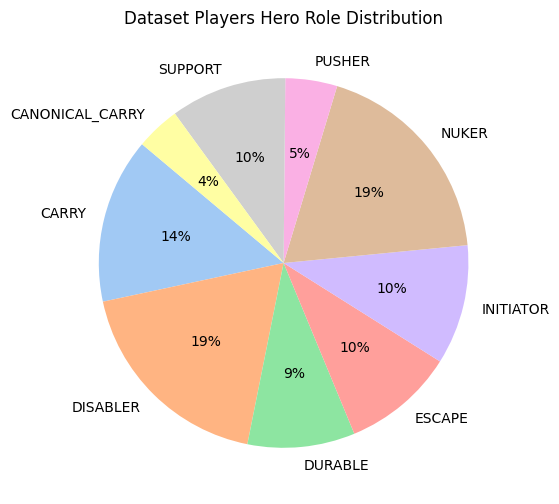

In [63]:
plt.figure(figsize=(10, 6)) 
colors = sns.color_palette('pastel')[0:len(df_stats_mean.index)]
plt.pie(df_stats_mean["count"], labels=df_stats_mean.index, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title("Dataset Players Hero Role Distribution") 
# plt.legend(title="Classes") 
plt.savefig(os.path.join(plots_out_dir, "hero_role_distr.png"))
plt.show()

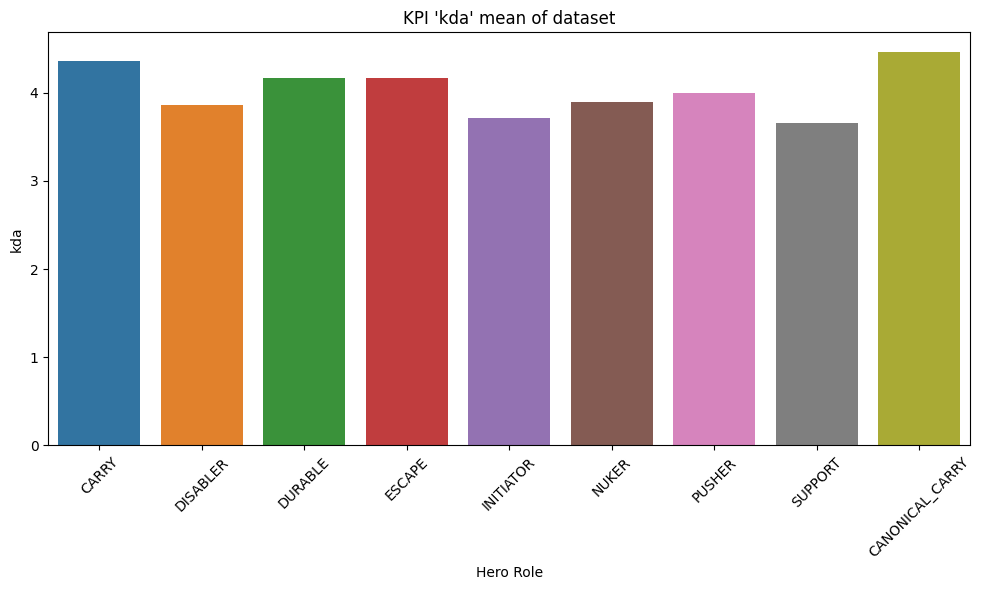

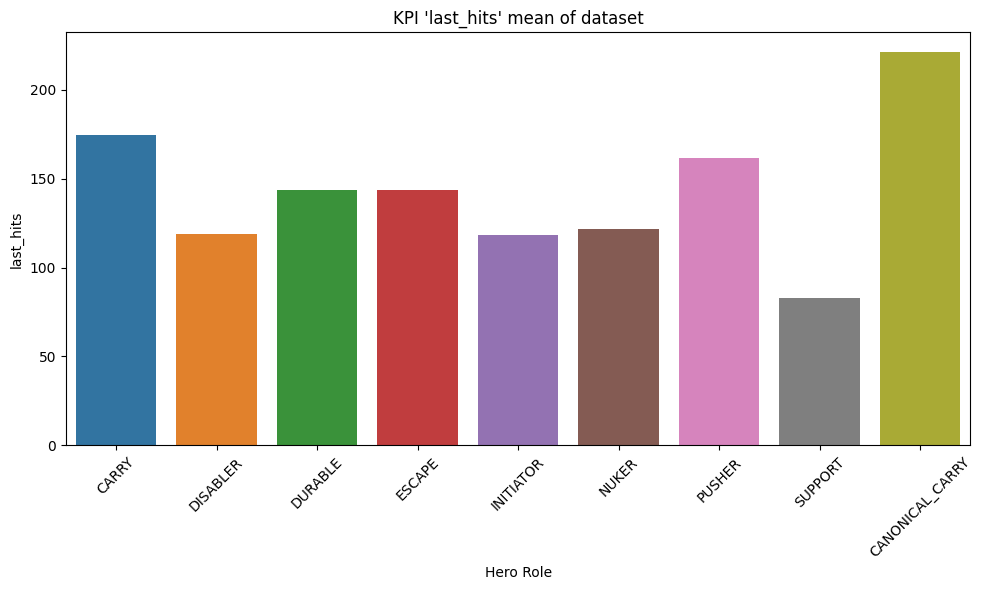

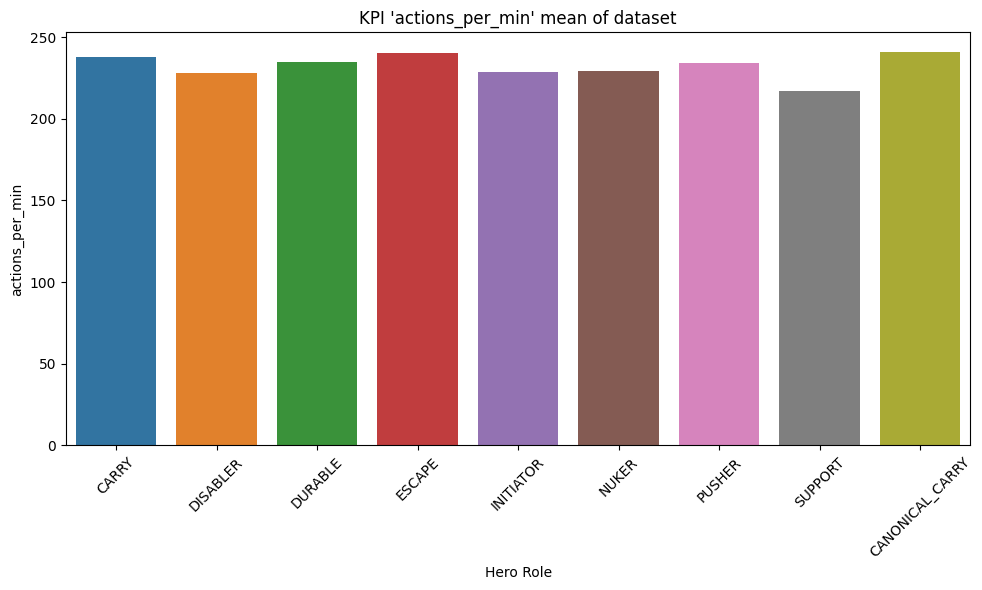

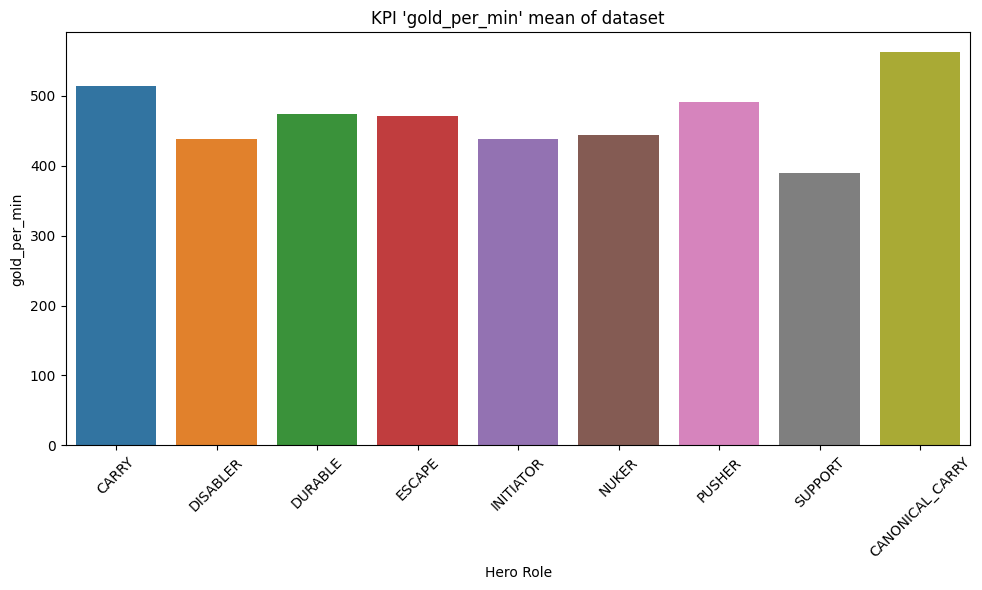

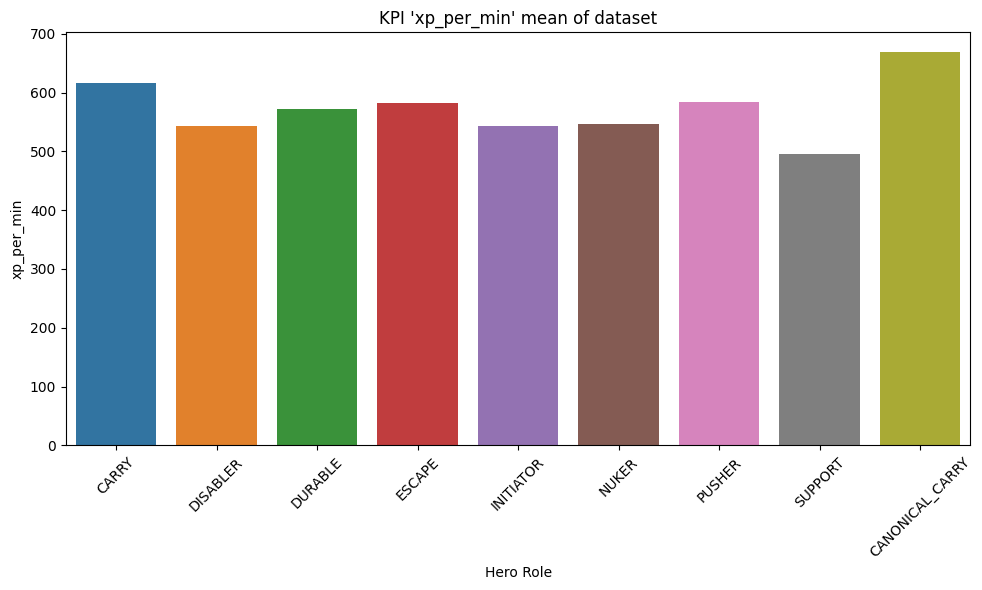

In [64]:
variables = ["kda", "last_hits", "actions_per_min", "gold_per_min", "xp_per_min"]

for var in variables:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.barplot(x=df_stats_mean.index, y=df_stats_mean[var], ax=ax, hue=df_stats_mean.index)
    ax.set_title(f"KPI '{var}' mean of dataset")
    ax.set_xlabel('Hero Role')
    ax.set_ylabel(var)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_out_dir, f"all_stats_mean_{var}.png"))
    plt.show()